# Fully-saturated TWFE

In [2]:
import re
import pandas as pd
import numpy as np
import japanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

In [3]:
filepath = '../../../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)

$$
Y_{it} = \alpha_i + \lambda_t + \sum_{k \notin C}\sum_{l \in L} \delta_{lk} \mathbf{1}[G_k=k]\mathbf{1}[t-k=l] + \epsilon_{it}
$$

## ベイズモデル

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pymc/model/core.py:1359: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


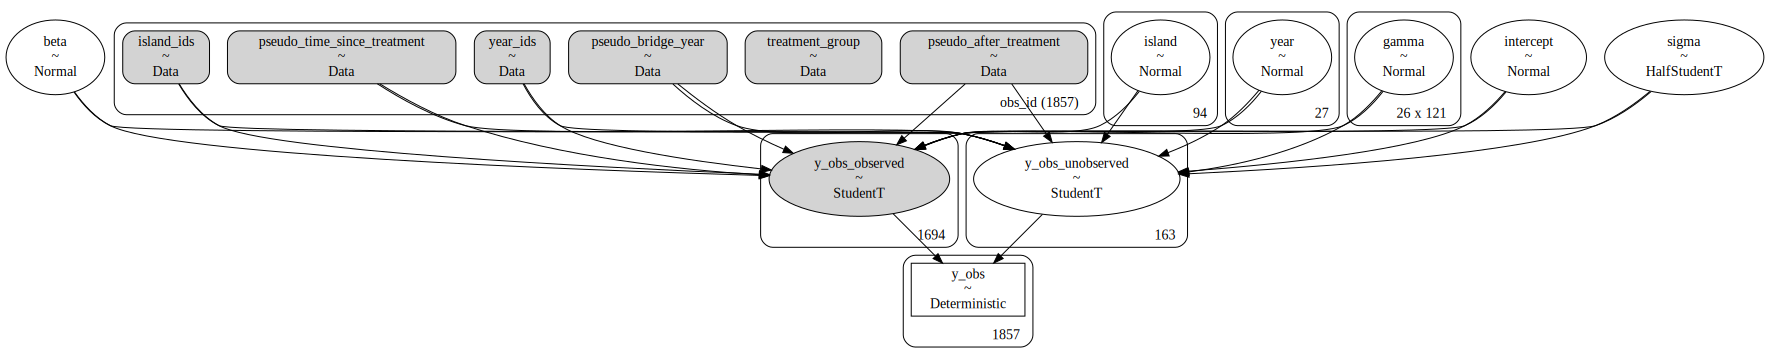

In [9]:
# 0から始まるインデックスを振り直す
df['island_ids'], unique_island_ids = pd.factorize(df['island_ids'])
df['year'], unique_year_ids = pd.factorize(df['year'])
df['pseudo_bridge_year'], unique_pseudo_bridge_year = pd.factorize(df['pseudo_bridge_year'])
df['pseudo_time_since_treatment'], unique_time_since_treatment = pd.factorize(df['pseudo_time_since_treatment'])

COORDS = {'obs_id': df.index}

with pm.Model(coords=COORDS) as fully_saturated:
    # data
    island_ids = pm.Data('island_ids', df['island_ids'], dims='obs_id')
    year_ids = pm.Data('year_ids', df['year'], dims='obs_id')
    pseudo_after_treatment = pm.Data('pseudo_after_treatment', df['pseudo_after_treatment'], dims='obs_id')
    treatment_group = pm.Data('treatment_group', df['treatment_group'], dims='obs_id')
    pseudo_time_since_treatment = pm.Data('pseudo_time_since_treatment', df['pseudo_time_since_treatment'], dims='obs_id')
    pseudo_bridge_year = pm.Data('pseudo_bridge_year', df['pseudo_bridge_year'], dims='obs_id')

    # priors
    # random effects
    island = pm.Normal('island', mu=0, sigma=1, shape=len(unique_island_ids))
    year = pm.Normal('year', mu=0, sigma=1, shape=len(unique_year_ids))
    gamma = pm.Normal('gamma', mu=0, sigma=1, shape=(len(unique_pseudo_bridge_year), len(unique_time_since_treatment)))

    # fixed effects
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=1)
    sigma = pm.HalfStudentT('sigma', nu=3, sigma=1)

    # expectation
    mu = intercept + (beta + gamma[pseudo_bridge_year, pseudo_time_since_treatment]) * pseudo_after_treatment + island[island_ids] + year[year_ids]

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=3, mu=mu, sigma=sigma, observed=df['log_pop'])

pm.model_to_graphviz(fully_saturated)

In [5]:
with fully_saturated:
    initvals = {'intercept': 5, 'beta': 0.4, 'sigma': 0.1}
    trace_fully_saturated = pm.sample(
        draws=9000,
        tune=1000,
        chains=2,
        cores=6,
        nuts_sampler='numpyro',
        random_seed=42,
        initvals=initvals,
        target_accept=.9
    )

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [10]:
with fully_saturated:
    pm.compute_log_likelihood(trace_fully_saturated)

Output()

In [6]:
az.summary(trace_fully_saturated, hdi_prob=.95, var_names=['intercept', 'beta', 'sigma'])

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,5.605,0.223,5.164,6.038,0.013,0.009,300.0,652.0,1.02
beta,0.408,0.081,0.247,0.561,0.007,0.005,126.0,1284.0,1.04
sigma,0.109,0.003,0.103,0.116,0.000,0.000,8888.0,12424.0,1.00


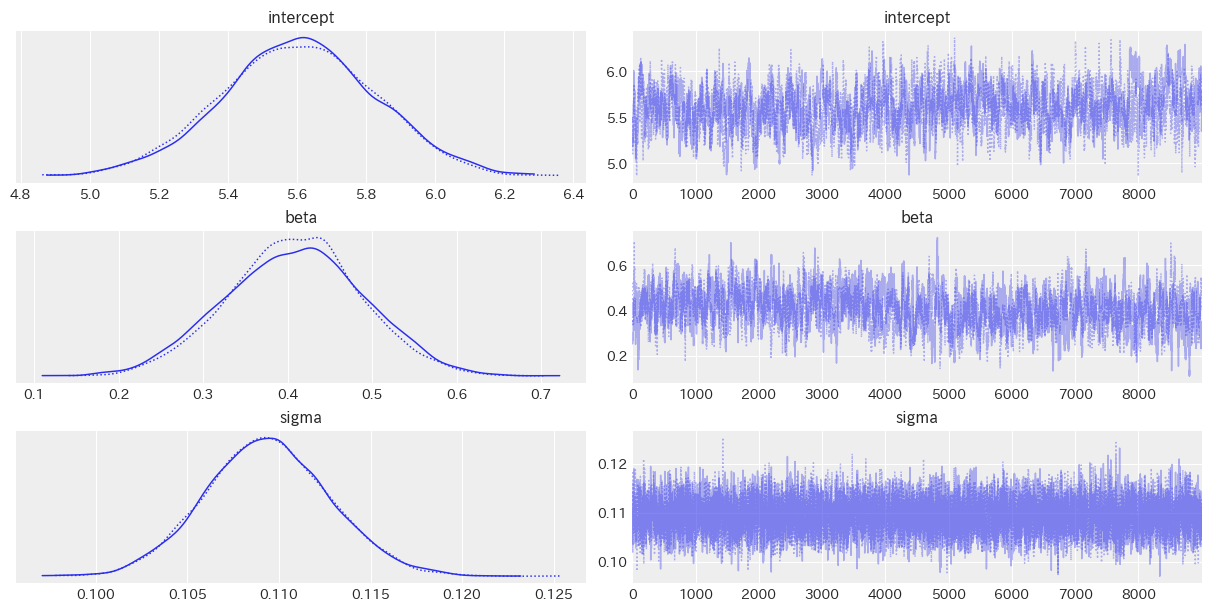

In [7]:
az.plot_trace(trace_fully_saturated, var_names=['intercept', 'beta', 'sigma']);

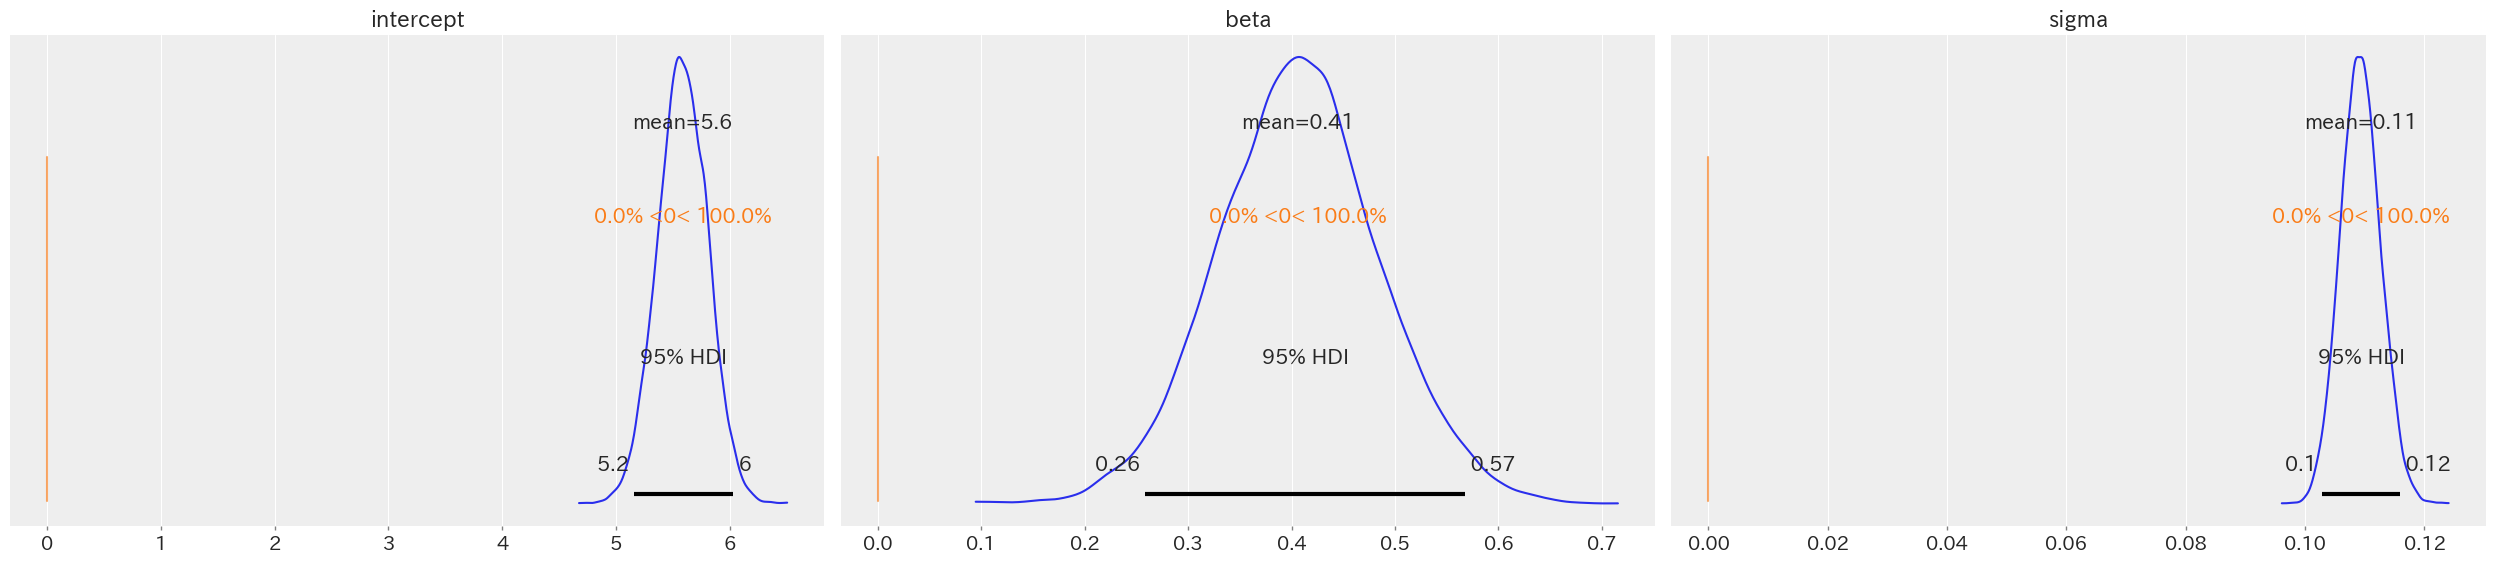

In [6]:
az.plot_posterior(trace_fully_saturated, var_names=['intercept', 'beta', 'sigma'], hdi_prob=.95, ref_val=0);

In [11]:
az.waic(trace_fully_saturated)

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 24000 posterior samples and 1694 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   277.49    64.47
p_waic      490.55        -

There has been a warning during the calculation. Please check the results.

## 階層ベイズモデル

### $\gamma$ に階層構造を仮定しない

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pymc/model/core.py:1359: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


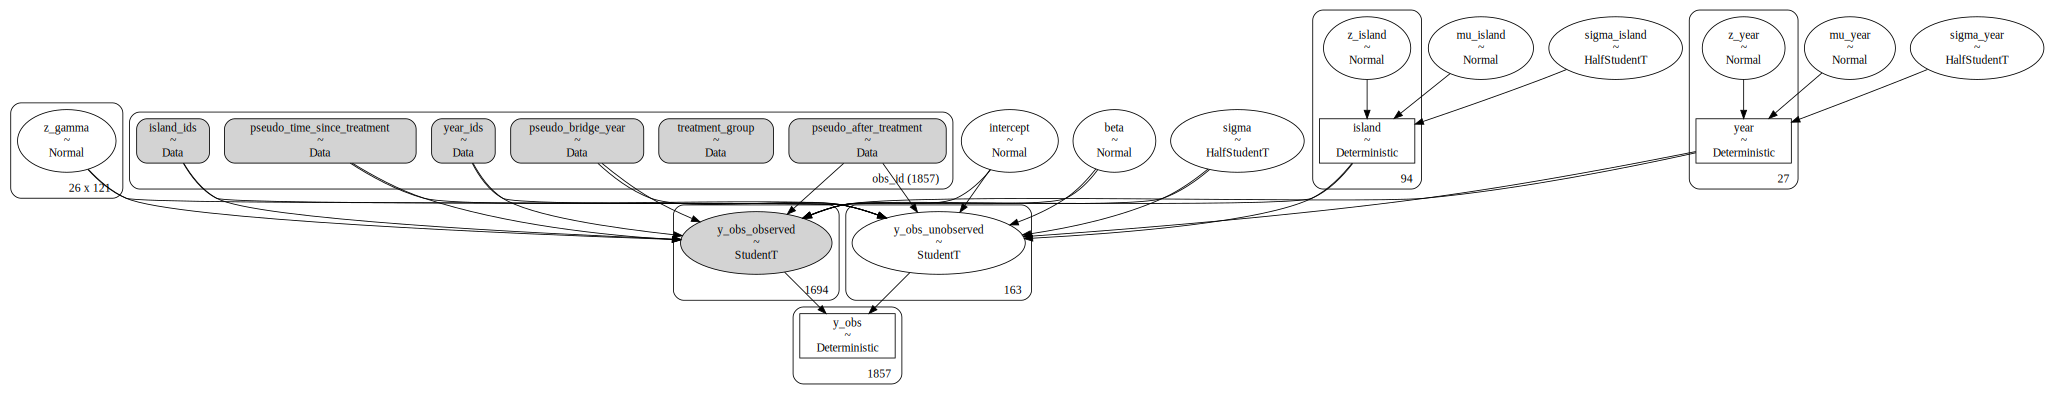

In [ ]:
# 0から始まるインデックスを振り直す
df['island_ids'], unique_island_ids = pd.factorize(df['island_ids'])
df['year'], unique_year_ids = pd.factorize(df['year'])
df['pseudo_bridge_year'], unique_pseudo_bridge_year = pd.factorize(df['pseudo_bridge_year'])
df['pseudo_time_since_treatment'], unique_time_since_treatment = pd.factorize(df['pseudo_time_since_treatment'])

COORDS = {'obs_id': df.index}

with pm.Model(coords=COORDS) as fully_saturated_h:
    # data
    island_ids = pm.Data('island_ids', df['island_ids'], dims='obs_id')
    year_ids = pm.Data('year_ids', df['year'], dims='obs_id')
    pseudo_after_treatment = pm.Data('pseudo_after_treatment', df['pseudo_after_treatment'], dims='obs_id')
    treatment_group = pm.Data('treatment_group', df['treatment_group'], dims='obs_id')
    pseudo_time_since_treatment = pm.Data('pseudo_time_since_treatment', df['pseudo_time_since_treatment'], dims='obs_id')
    pseudo_bridge_year = pm.Data('pseudo_bridge_year', df['pseudo_bridge_year'], dims='obs_id')

    # priors
    # random effects
    mu_island = pm.Normal('mu_island', mu=0, sigma=1)
    sigma_island = pm.HalfStudentT('sigma_island', nu=3, sigma=1)
    z_island = pm.Normal('z_island', mu=0, sigma=1, shape=len(unique_island_ids))
    island = pm.Deterministic('island', mu_island + sigma_island * z_island)

    mu_year = pm.Normal('mu_year', mu=0, sigma=1)
    sigma_year = pm.HalfStudentT('sigma_year', nu=3, sigma=1)
    z_year = pm.Normal('z_year', mu=0, sigma=1, shape=len(unique_year_ids))
    year = pm.Deterministic('year', mu_year + sigma_year * z_year)

    gamma = pm.Normal('gamma', mu=0, sigma=1, shape=(len(unique_pseudo_bridge_year), len(unique_time_since_treatment)))

    # fixed effects
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=1)
    sigma = pm.HalfStudentT('sigma', nu=3, sigma=1)

    # expectation
    mu = intercept + (beta + gamma[pseudo_bridge_year, pseudo_time_since_treatment]) * pseudo_after_treatment + island[island_ids] + year[year_ids]

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=3, mu=mu, sigma=sigma, observed=df['log_pop'])

pm.model_to_graphviz(fully_saturated_h)

In [13]:
with fully_saturated_h:
    initvals = {'intercept': 5, 'beta': 0.4, 'sigma': 0.1}
    trace_fully_saturated_h = pm.sample(
        draws=2000,
        tune=1000,
        chains=2,
        cores=6,
        nuts_sampler='numpyro',
        random_seed=42,
        initvals=initvals,
    )

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [15]:
az.summary(
    trace_fully_saturated_h,
    hdi_prob=.95,
    var_names=['intercept', 'beta', 'sigma']
)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,5.613,1.380,2.824,8.157,0.078,0.055,317.0,716.0,1.00
beta,0.342,0.074,0.197,0.479,0.020,0.015,15.0,56.0,1.10
sigma,0.109,0.003,0.102,0.115,0.000,0.000,371.0,1034.0,1.01


In [22]:
with fully_saturated_h:
    pm.compute_log_likelihood(trace_fully_saturated_h)

az.waic(trace_fully_saturated_h)

Output()

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 1694 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   324.54    57.05
p_waic      443.90        -

There has been a warning during the calculation. Please check the results.

### $\gamma$ を階層ベイズモデルに

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pymc/model/core.py:1359: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


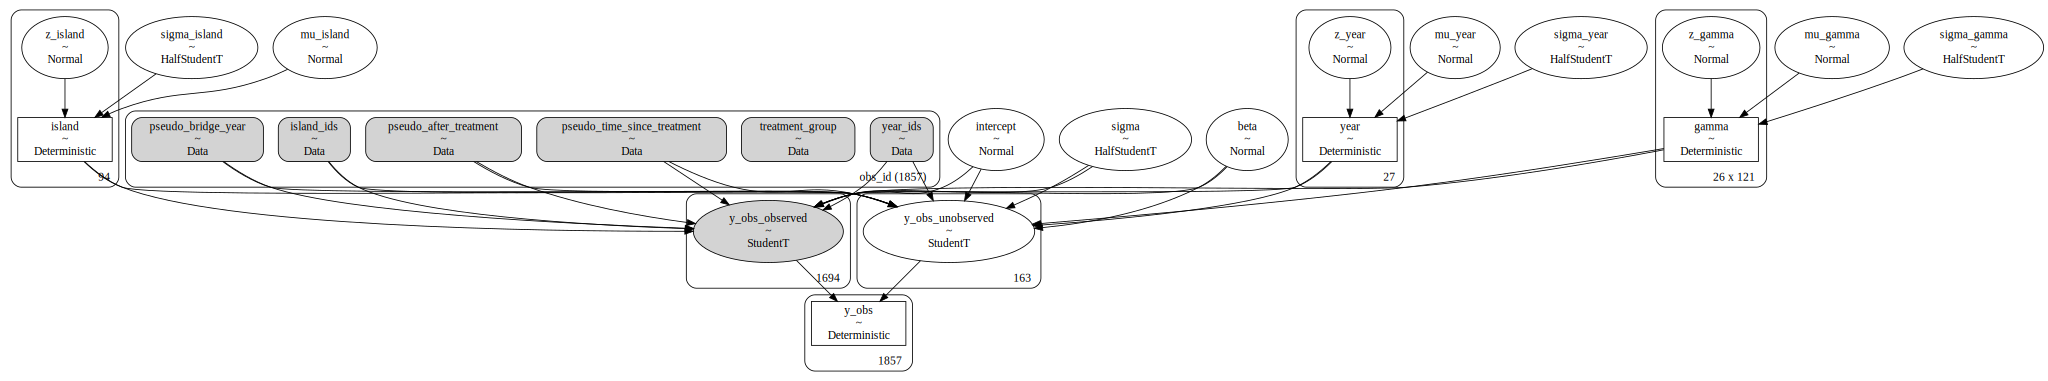

In [ ]:
# 0から始まるインデックスを振り直す
df['island_ids'], unique_island_ids = pd.factorize(df['island_ids'])
df['year'], unique_year_ids = pd.factorize(df['year'])
df['pseudo_bridge_year'], unique_pseudo_bridge_year = pd.factorize(df['pseudo_bridge_year'])
df['pseudo_time_since_treatment'], unique_time_since_treatment = pd.factorize(df['pseudo_time_since_treatment'])

COORDS = {'obs_id': df.index}

with pm.Model(coords=COORDS) as fully_saturated_h:
    # data
    island_ids = pm.Data('island_ids', df['island_ids'], dims='obs_id')
    year_ids = pm.Data('year_ids', df['year'], dims='obs_id')
    pseudo_after_treatment = pm.Data('pseudo_after_treatment', df['pseudo_after_treatment'], dims='obs_id')
    treatment_group = pm.Data('treatment_group', df['treatment_group'], dims='obs_id')
    pseudo_time_since_treatment = pm.Data('pseudo_time_since_treatment', df['pseudo_time_since_treatment'], dims='obs_id')
    pseudo_bridge_year = pm.Data('pseudo_bridge_year', df['pseudo_bridge_year'], dims='obs_id')

    # priors
    # random effects
    mu_island = pm.Normal('mu_island', mu=0, sigma=1)
    sigma_island = pm.HalfStudentT('sigma_island', nu=3, sigma=1)
    z_island = pm.Normal('z_island', mu=0, sigma=1, shape=len(unique_island_ids))
    island = pm.Deterministic('island', mu_island + sigma_island * z_island)

    mu_year = pm.Normal('mu_year', mu=0, sigma=1)
    sigma_year = pm.HalfStudentT('sigma_year', nu=3, sigma=1)
    z_year = pm.Normal('z_year', mu=0, sigma=1, shape=len(unique_year_ids))
    year = pm.Deterministic('year', mu_year + sigma_year * z_year)

    mu_gamma = pm.Normal('mu_gamma', mu=0, sigma=1)
    sigma_gamma = pm.HalfStudentT('sigma_gamma', nu=3, sigma=1)
    z_gamma = pm.Normal('z_gamma', mu=0, sigma=1, shape=(len(unique_pseudo_bridge_year), len(unique_time_since_treatment)))
    gamma = pm.Deterministic('gamma', mu_gamma + sigma_gamma * z_gamma)

    # fixed effects
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=1)
    sigma = pm.HalfStudentT('sigma', nu=3, sigma=1)

    # expectation
    mu = intercept + (beta + gamma[pseudo_bridge_year, pseudo_time_since_treatment]) * pseudo_after_treatment + island[island_ids] + year[year_ids]

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=3, mu=mu, sigma=sigma, observed=df['log_pop'])

pm.model_to_graphviz(fully_saturated_h)

In [5]:
with fully_saturated_h:
    trace_fully_saturated_h = pm.sample(
        draws=5000,
        tune=1500,
        chains=2,
        cores=4,
        nuts_sampler='numpyro',
        random_seed=42
    )
    pm.compute_log_likelihood(trace_fully_saturated_h)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/6500 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

In [7]:
az.summary(trace_fully_saturated_h, hdi_prob=.95, var_names=['intercept', 'beta', 'sigma'])

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,5.783,1.415,3.012,8.488,0.048,0.034,857.0,1954.0,1.0
beta,0.068,0.720,-1.448,1.377,0.025,0.018,821.0,1587.0,1.0
sigma,0.114,0.003,0.108,0.121,0.000,0.000,1033.0,2294.0,1.0


In [14]:
az.waic(trace_fully_saturated_h)

NameError: name 'trace_fully_saturated_h' is not defined

## サンプリングの保存

In [ ]:
# az.to_netcdf(trace_fully_saturated, './sample/trace_fully_saturated_log.nc')
# az.to_netcdf(trace_fully_saturated_h_no_gamma, './sample/trace_fully_saturated_h_log_no_gamma.nc')
# az.to_netcdf(trace_fully_saturated_h, './sample/trace_fully_saturated_h_log.nc')

'./sample/trace_fully_saturated_h_log_no_gamma.nc'

## サンプリングのインポート

In [ ]:
# trace_fully_saturated = az.from_netcdf('./sample/trace_fully_saturated_log.nc')
# trace_fully_saturated_h = az.from_netcdf('./sample/trace_fully_saturated_h_log.nc')

## ランダム効果の可視化

In [25]:
def get_beta_df(trace):
    # デルタのサマリーを取得
    beta_df = az.summary(trace, var_names=['beta'], hdi_prob=0.95, kind='stats')
    return beta_df

def get_gamma_df(trace):
    # デルタのサマリーを取得
    gamma_df = az.summary(trace, var_names=['gamma'], hdi_prob=0.95, kind='stats')

    # 正規表現を使用してインデックスから介入年と経過年数を抽出
    extracted = gamma_df.index.to_series().str.extract(r'gamma\[(\d+),\s*(\d+)\]')
    gamma_df['treat'] = extracted[0].astype(int)
    gamma_df['ell'] = extracted[1].astype(int)

    df = pd.read_excel(filepath)
    pseudo_bridge_year = df['pseudo_bridge_year'].unique()
    treat = gamma_df['treat'].unique()

    pseudo_bridge_year, treat

    gamma_df['treat'] = gamma_df['treat'].map(dict(enumerate(pseudo_bridge_year)))

    pseudo_time_since_treatment = df['pseudo_time_since_treatment'].unique()

    gamma_df['ell'] = gamma_df['ell'].map(dict(enumerate(pseudo_time_since_treatment)))

    gamma_df['exp_mean'] = np.exp(gamma_df['mean']) - 1
    gamma_df['exp_hdi_2.5%'] = np.exp(gamma_df['hdi_2.5%']) - 1
    gamma_df['exp_hdi_97.5%'] = np.exp(gamma_df['hdi_97.5%']) - 1

    return gamma_df

In [75]:
def plot_random_effect(gamma_df, treat, exp=False, errbar=False, save=False):
    plt.figure(figsize=(12, 6))
    # 介入年のデータフレームを取得
    gamma_treat_df = gamma_df[gamma_df['treat'] == treat]

    # 指数化するかどうか
    if exp:
        mean = 'exp_mean'
        hdi_2_5 = 'exp_hdi_2.5%'
        hdi_97_5 = 'exp_hdi_97.5%'
        log_or_percent = '%'
        log_or_exp = '指数'
    else:
        mean = 'mean'
        hdi_2_5 = 'hdi_2.5%'
        hdi_97_5 = 'hdi_97.5%'
        log_or_percent = '対数値'
        log_or_exp = '対数'


    sns.scatterplot(
        x='ell',
        y=mean,
        data=gamma_treat_df,
        color='black',
        label='mean',
        marker='o'
        )

    # エラーバーを表示するかどうか
    if errbar == True:
        plt.errorbar(
                    x=gamma_treat_df['ell'],
                    y=gamma_treat_df[mean],
                    yerr=[
                        gamma_treat_df[mean] - gamma_treat_df[hdi_2_5],
                        gamma_treat_df[hdi_97_5] - gamma_treat_df[mean]
                    ],
                    fmt='o',
                    capsize=5,
                    color='black',
                    label='95% HDI'
                )

    plt.axhline(y=0, color='red', linestyle='-')
    plt.axvline(x=0, color='red', linestyle='-')
    plt.xlabel('介入からの経過年数')
    plt.ylabel(f'介入のランダム効果({log_or_percent})')
    plt.title(f'{treat}年に開通した橋のランダム効果({log_or_exp})')
    plt.legend()

    # 保存するかどうか
    if save:
        plt.savefig(f'./{treat}_random_effect.png')

    plt.show()

In [35]:
gamma_df = get_gamma_df(trace_fully_saturated)
df = pd.read_excel(filepath)
treat_list = df['pseudo_bridge_year'].unique()
treat_list.sort()

In [48]:
print(treat_list)
num_treat = len(treat_list)-1
year_gap = treat_list[-1] - treat_list[1] + 1
print(num_treat, year_gap)

[   0 1889 1935 1951 1957 1961 1965 1968 1970 1971 1973 1975 1976 1979
 1983 1988 1992 1995 1996 1999 2000 2004 2008 2011 2015 2018]
25 130


In [ ]:
gamma_df = get_gamma_df(trace_fully_saturated)
df = pd.read_excel(filepath)
treat_list = df['pseudo_bridge_year'].unique()
treat_list.sort()

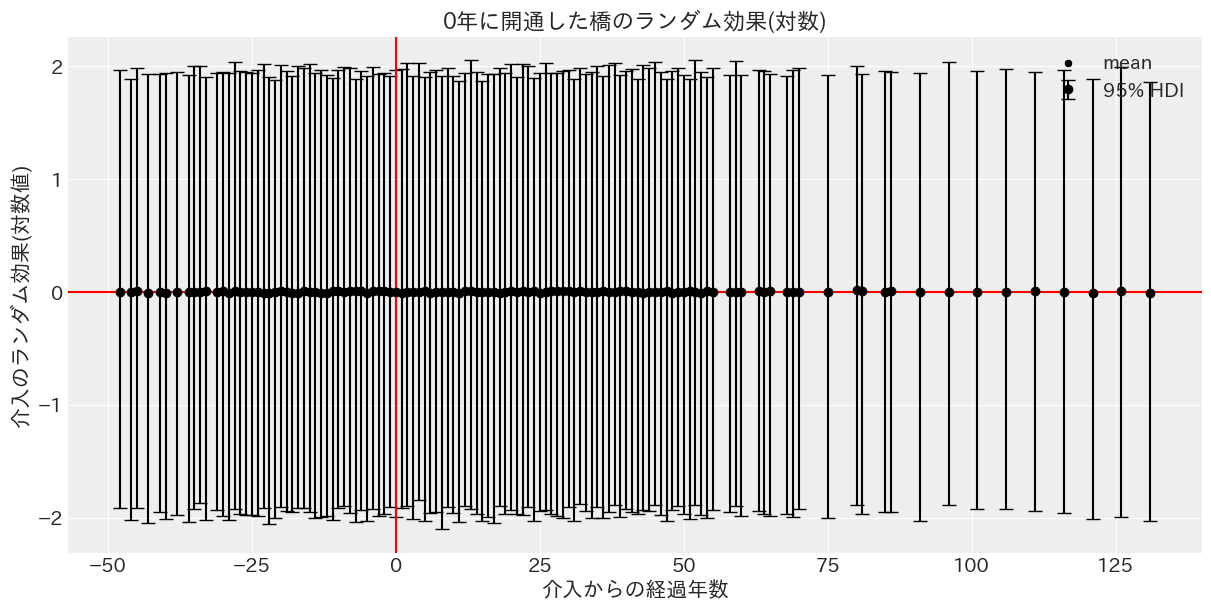

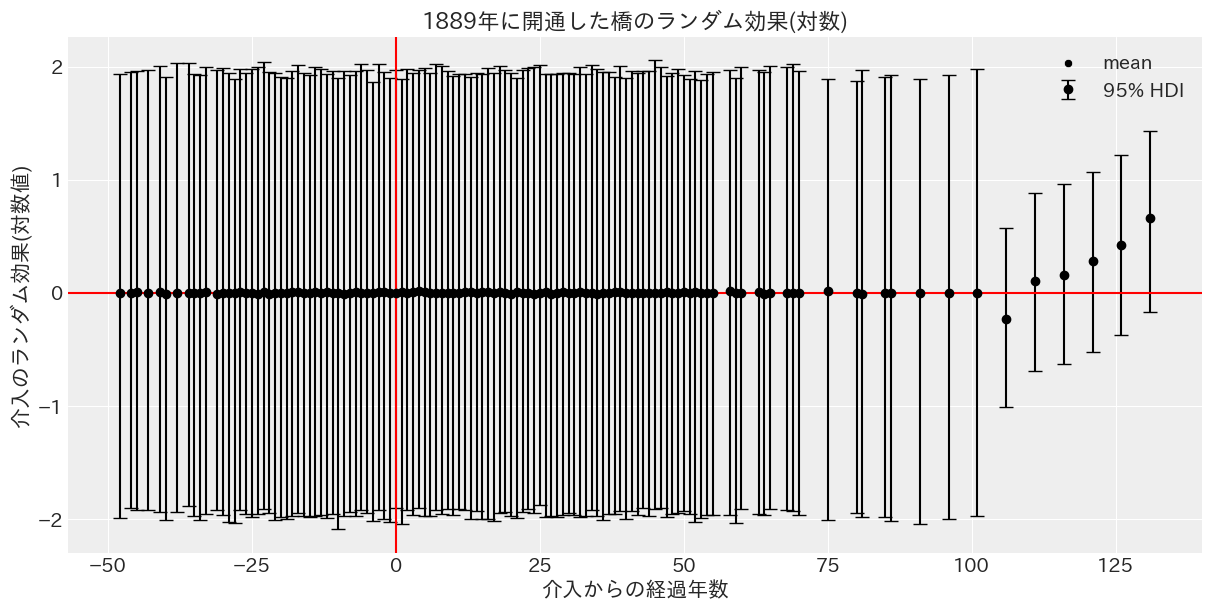

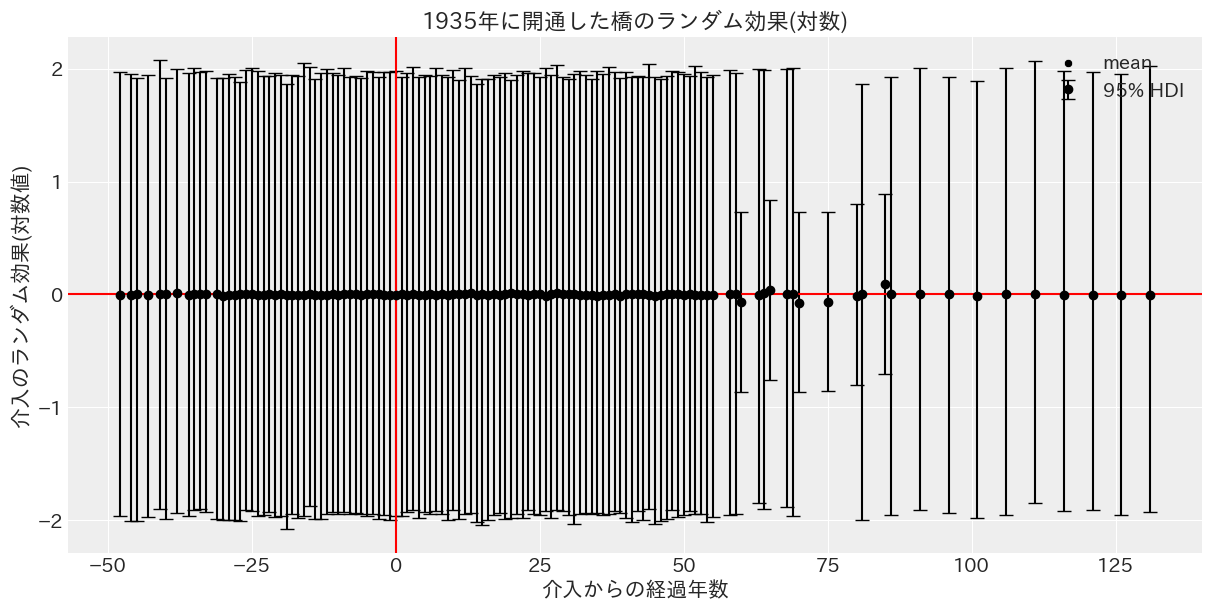

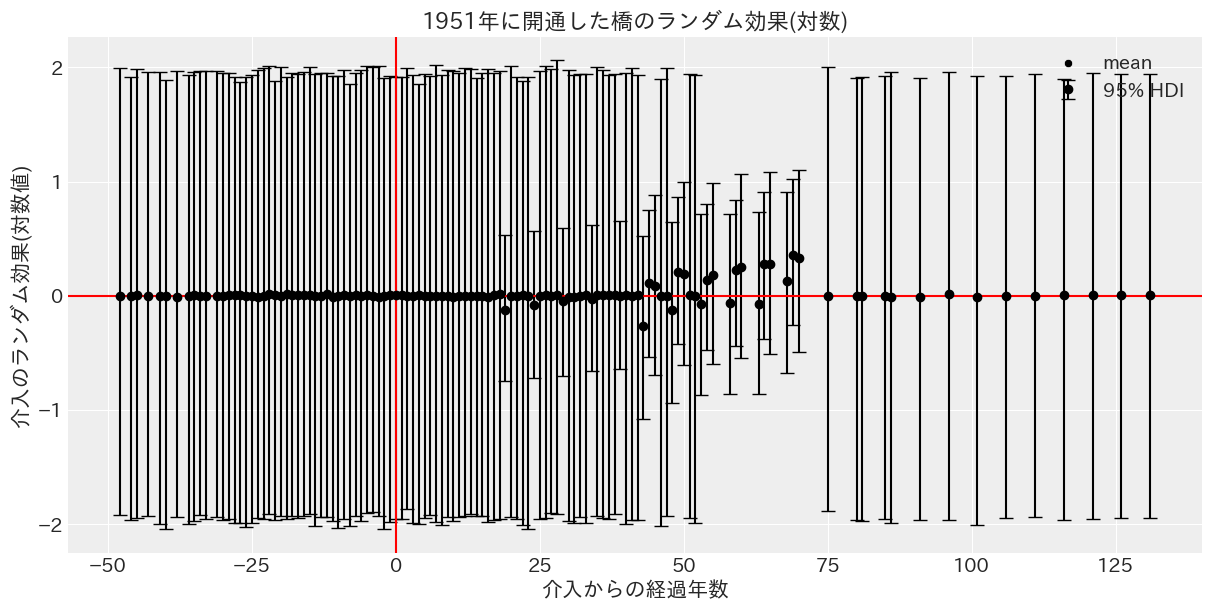

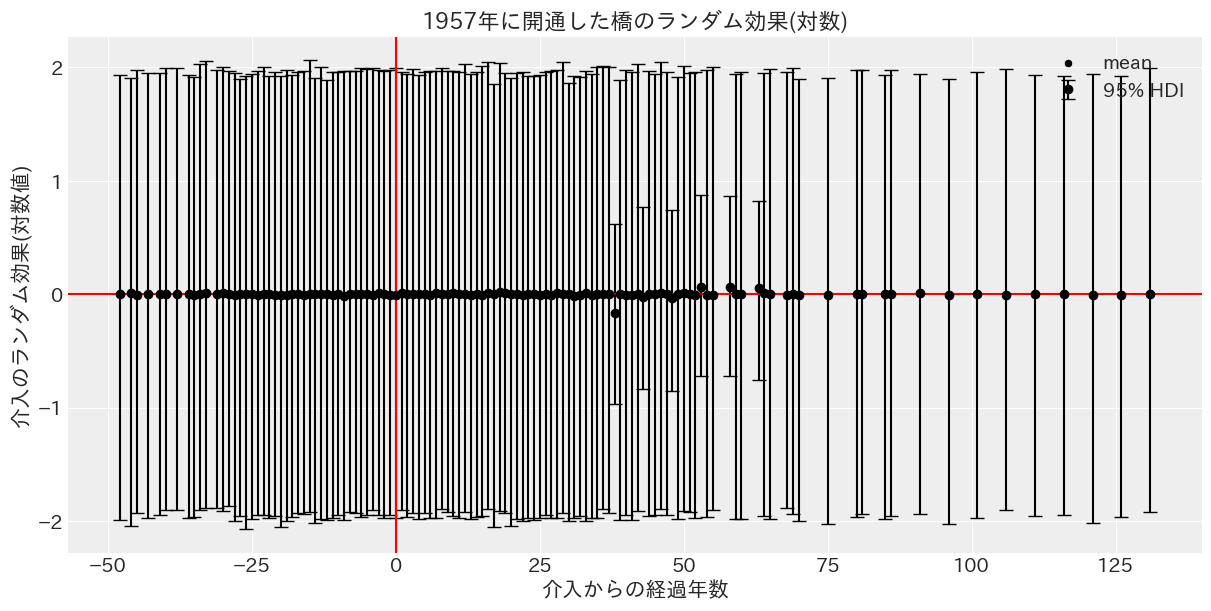

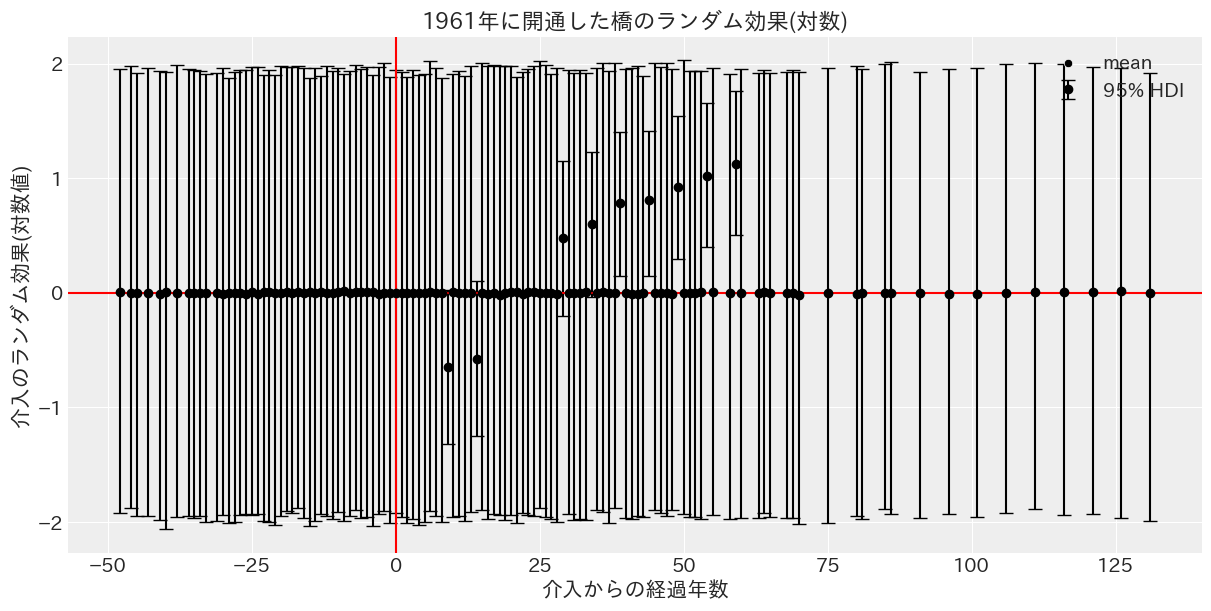

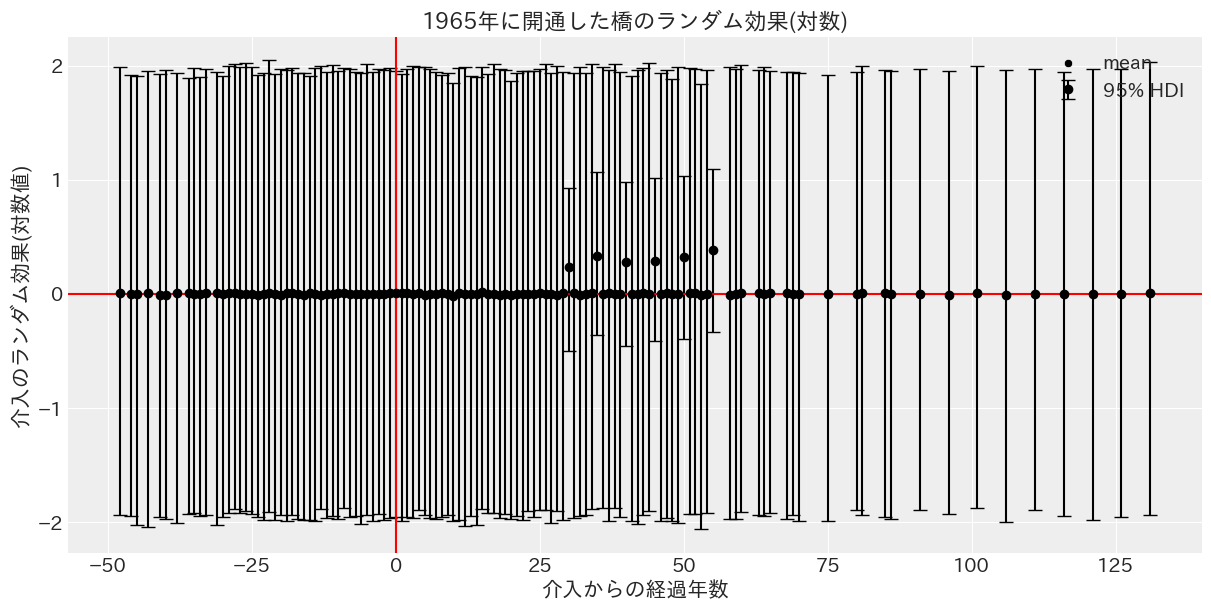

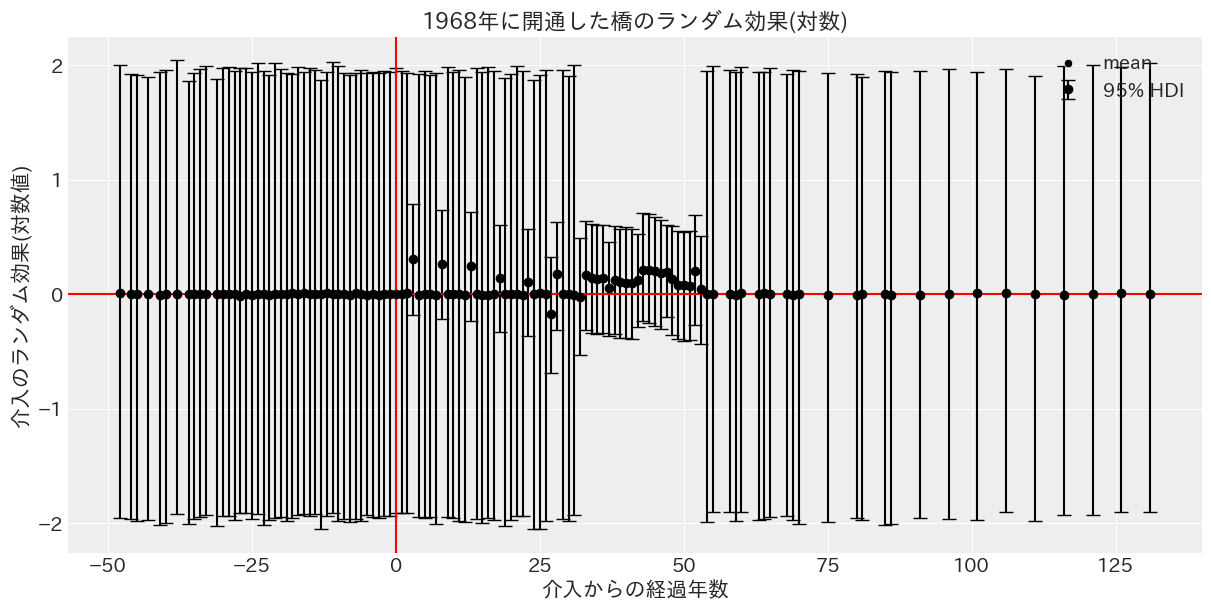

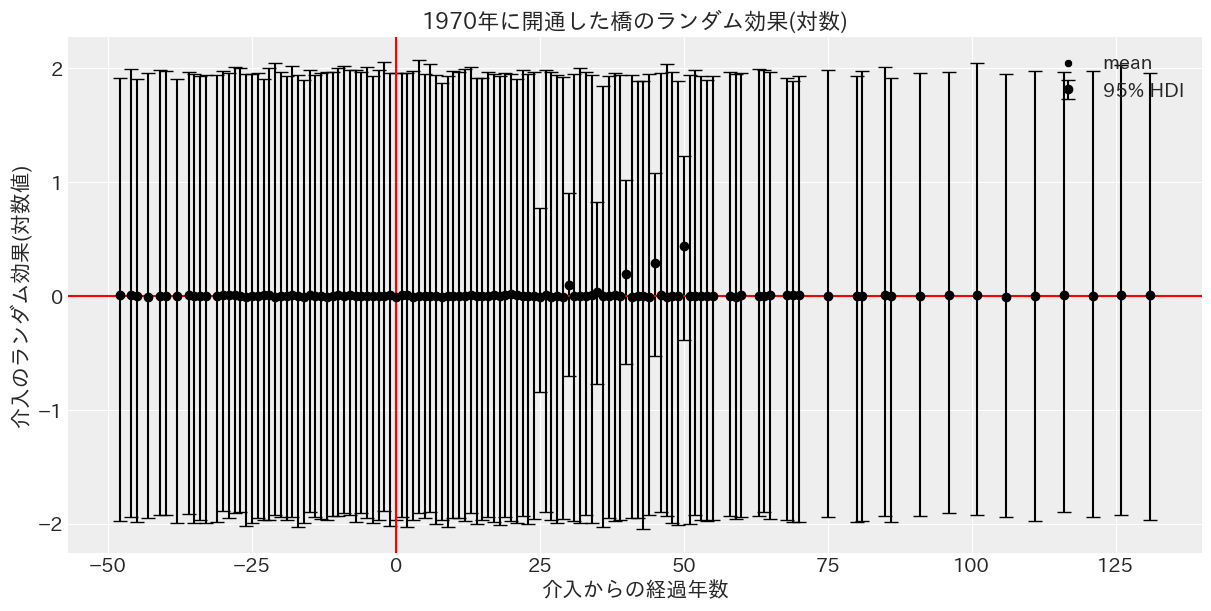

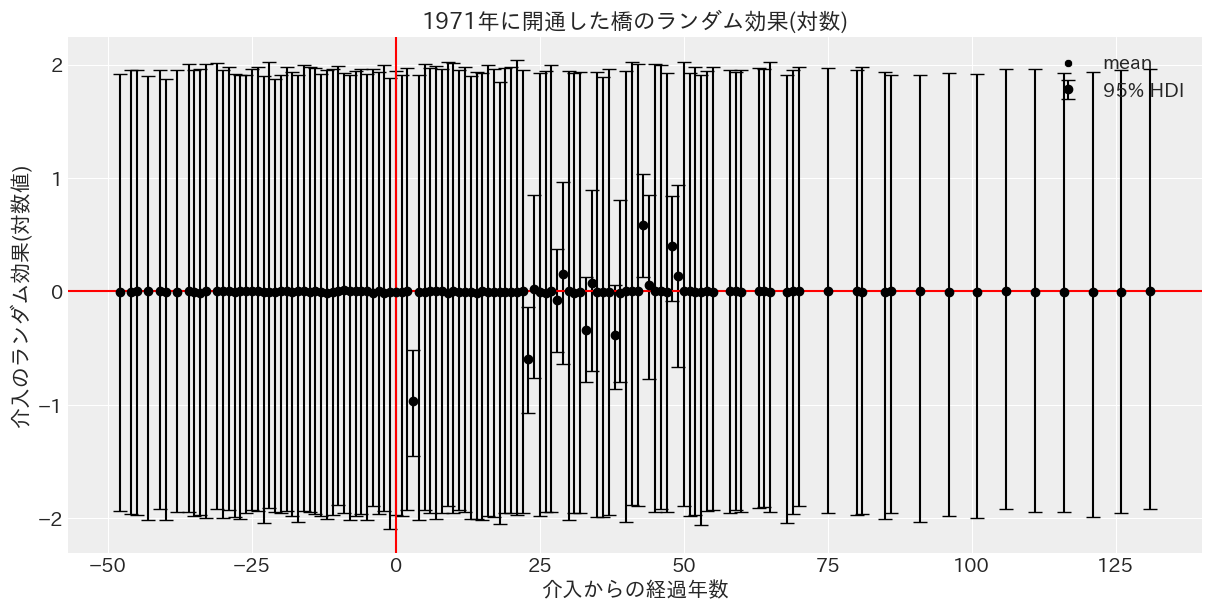

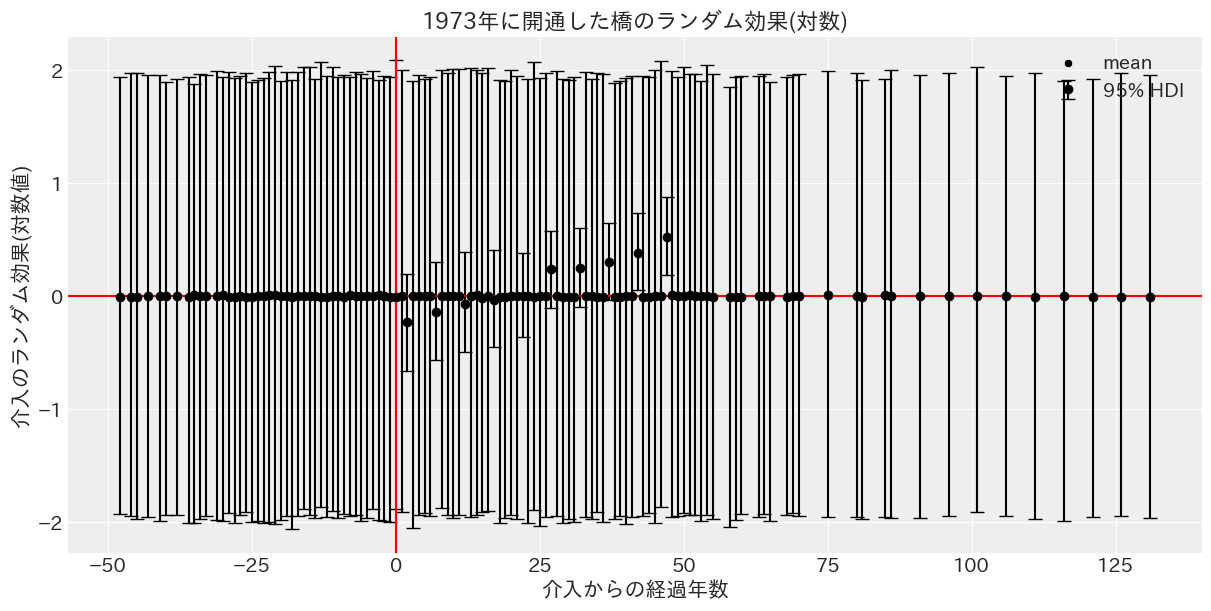

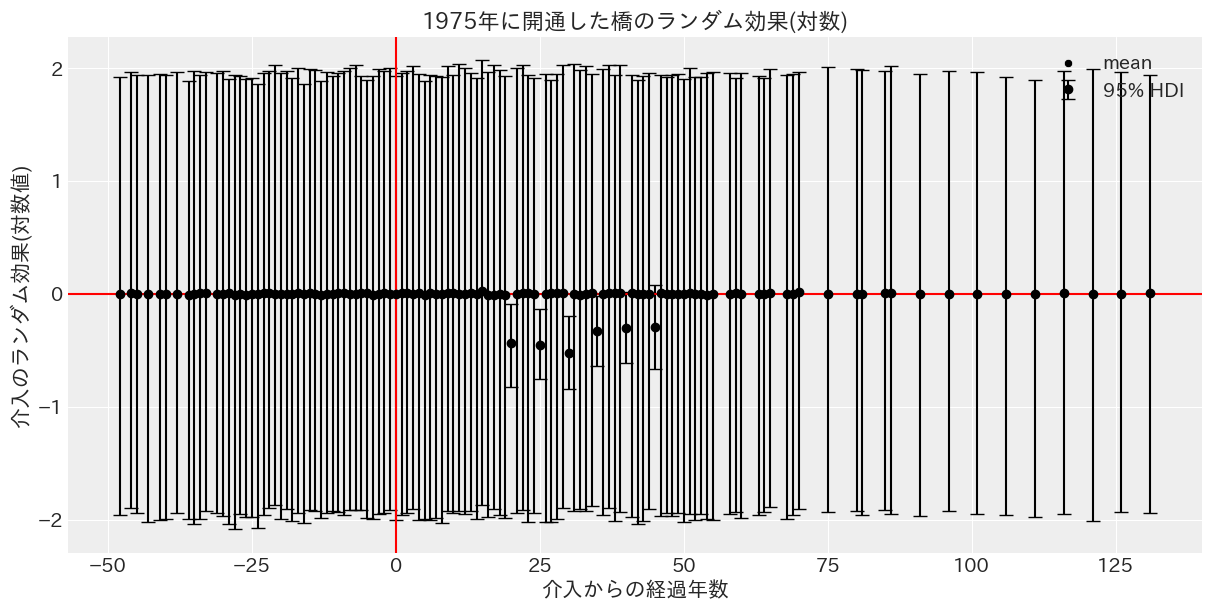

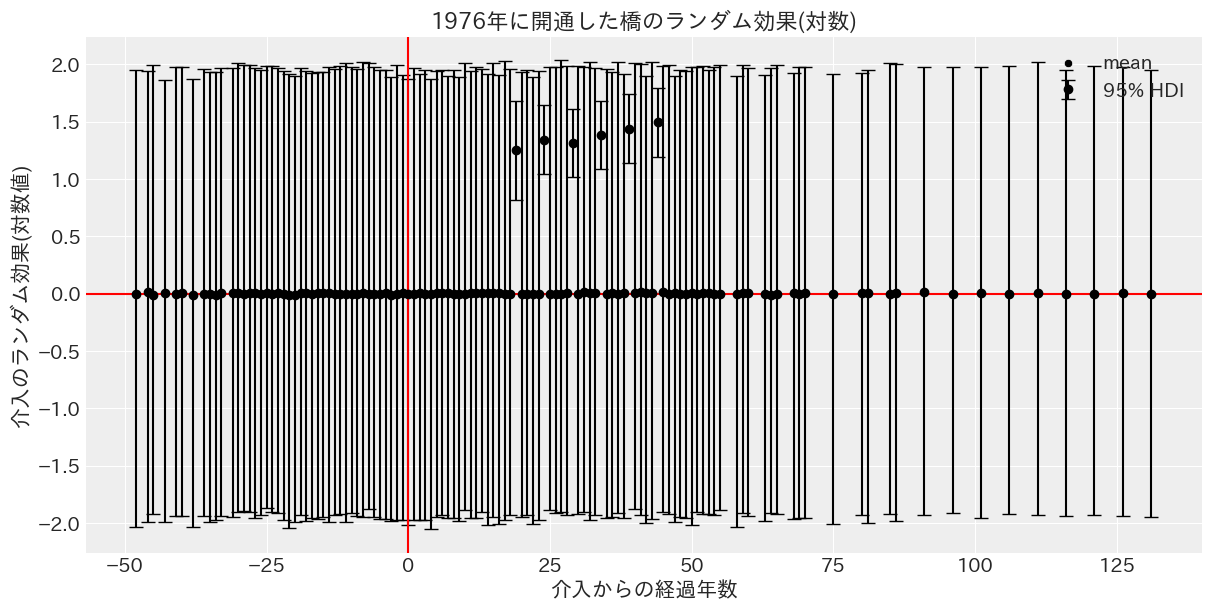

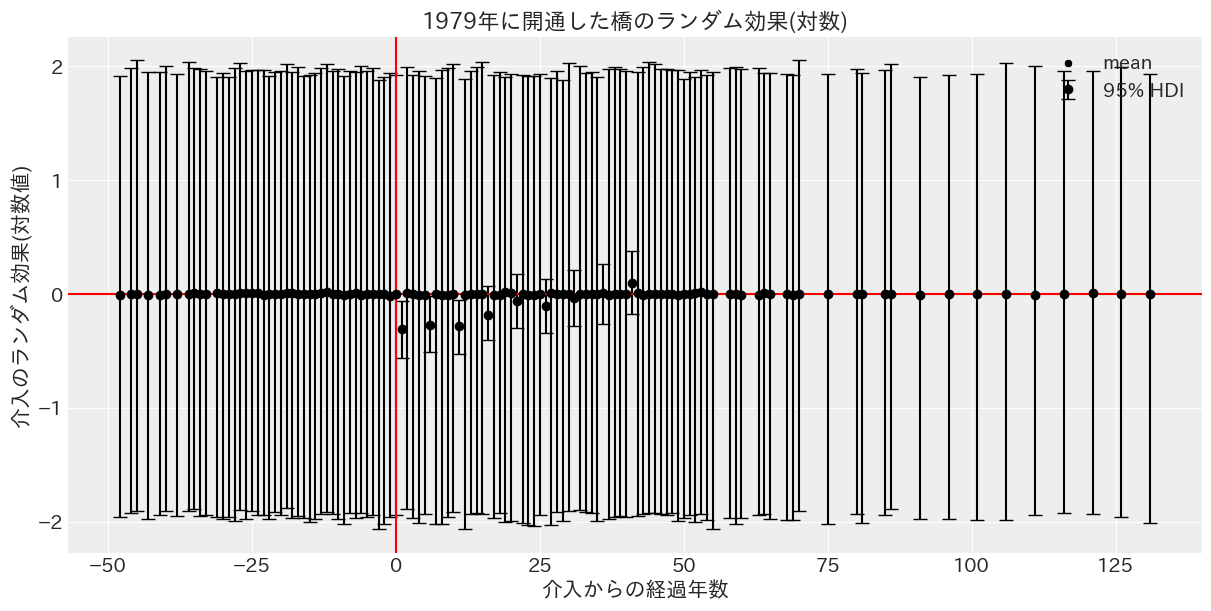

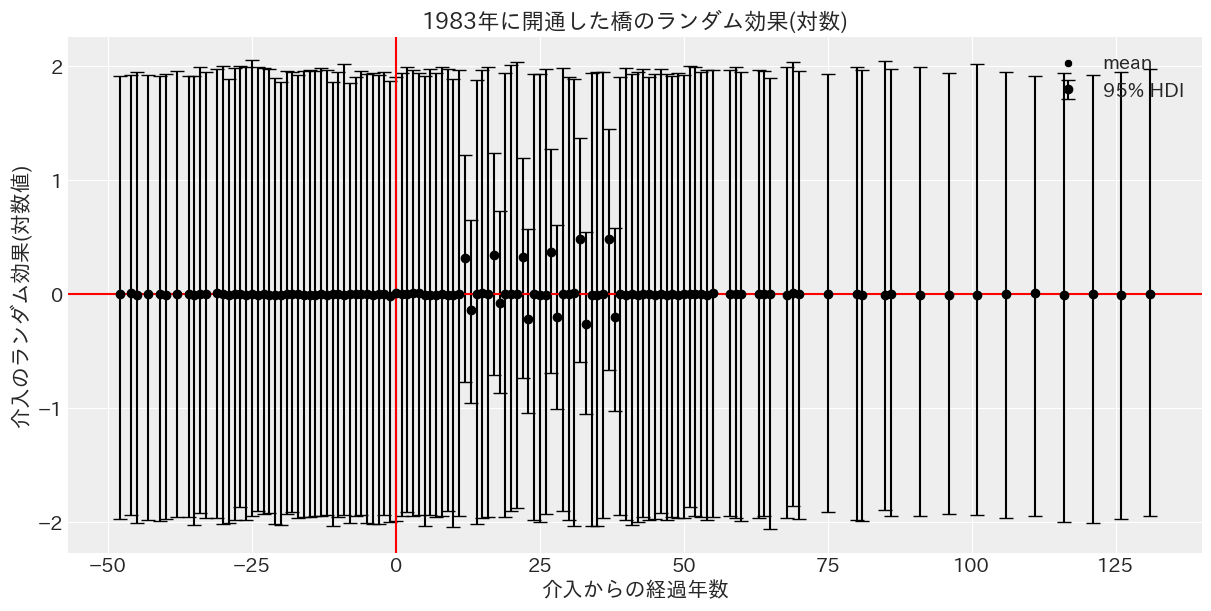

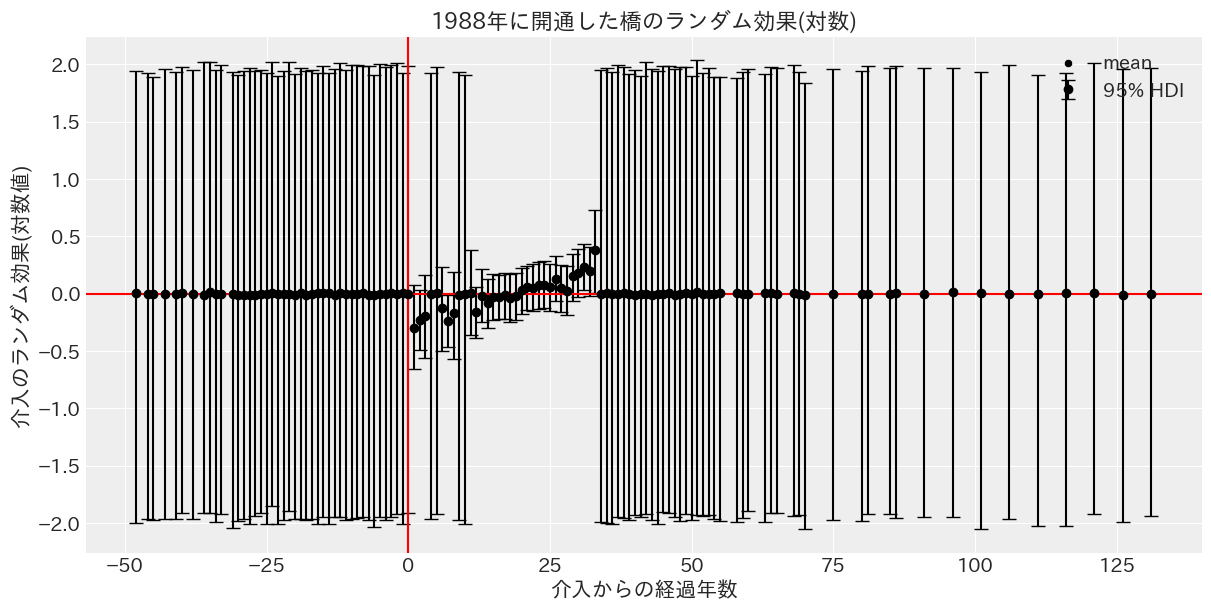

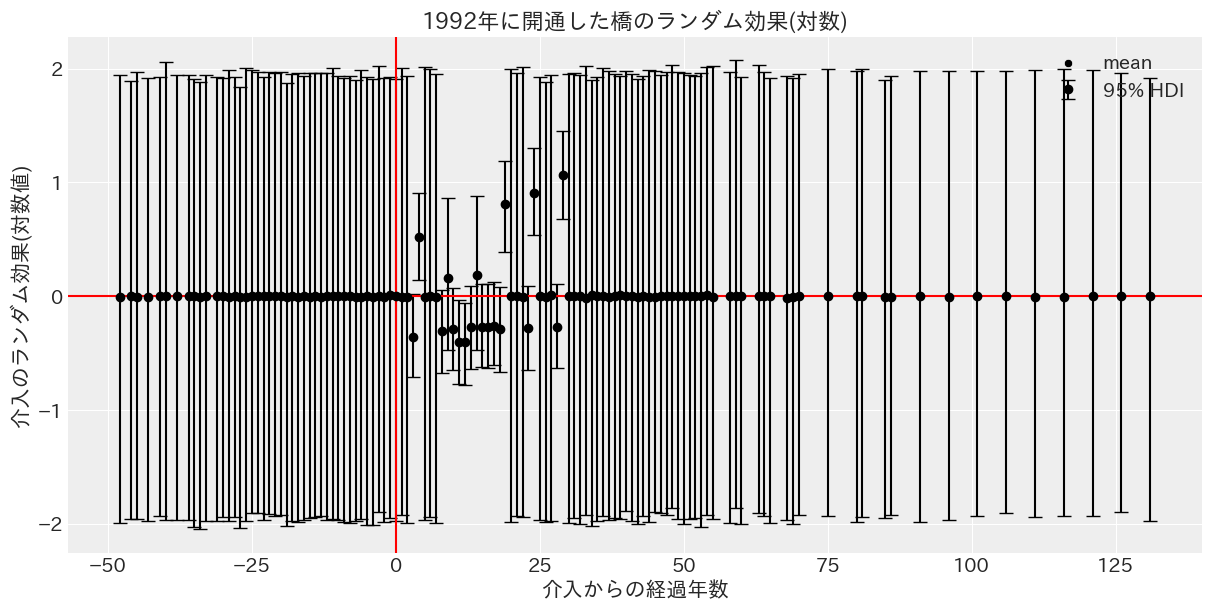

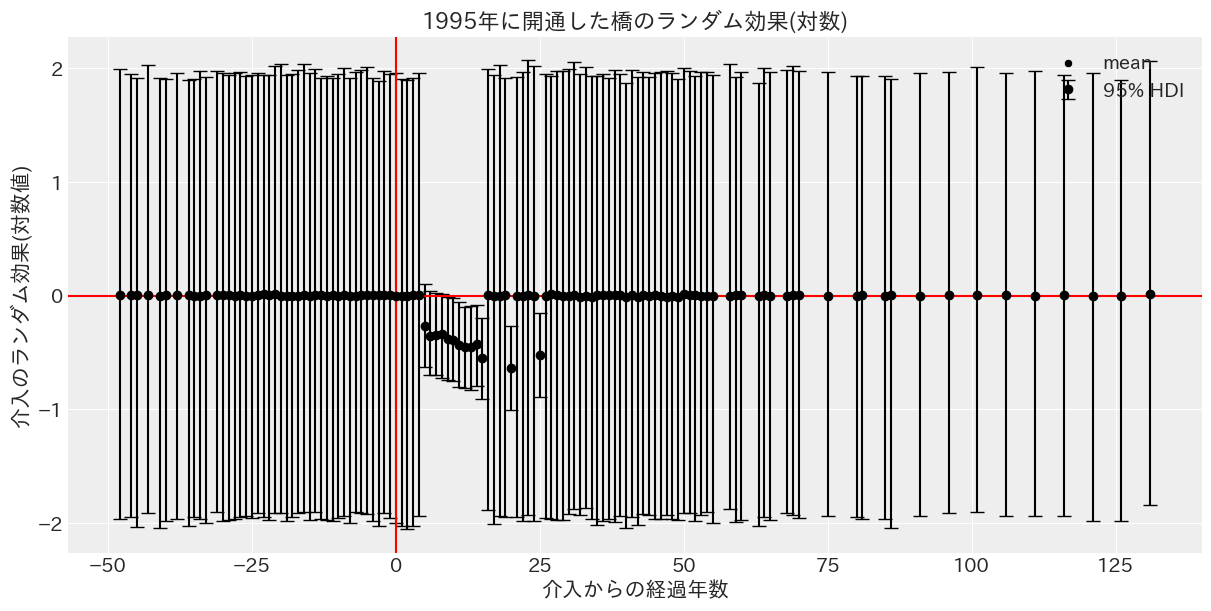

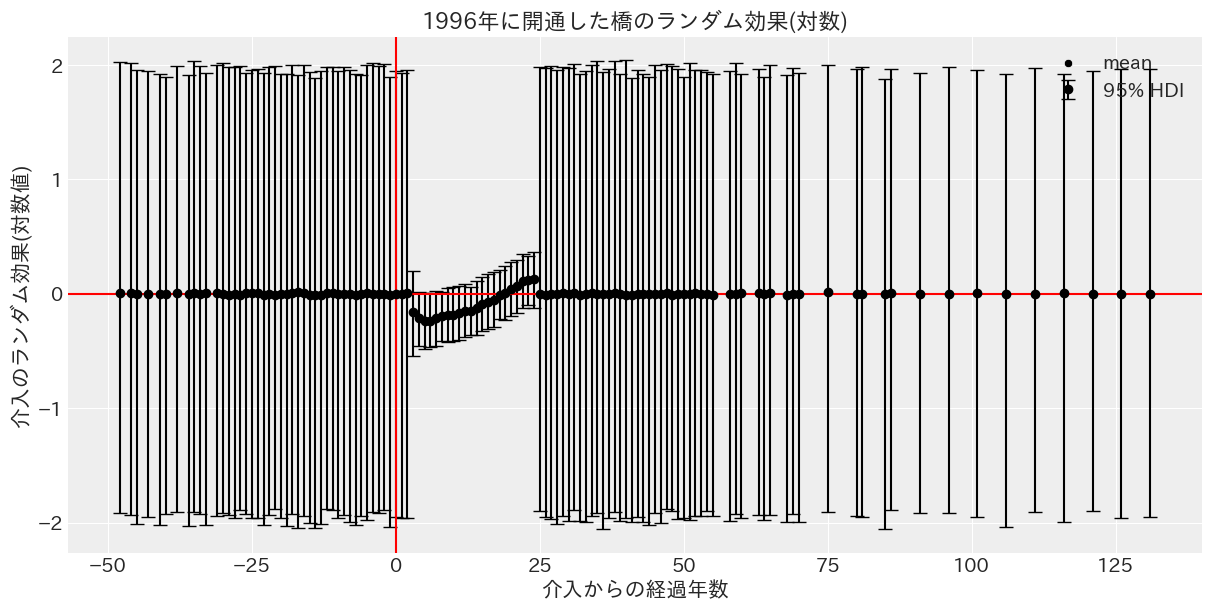

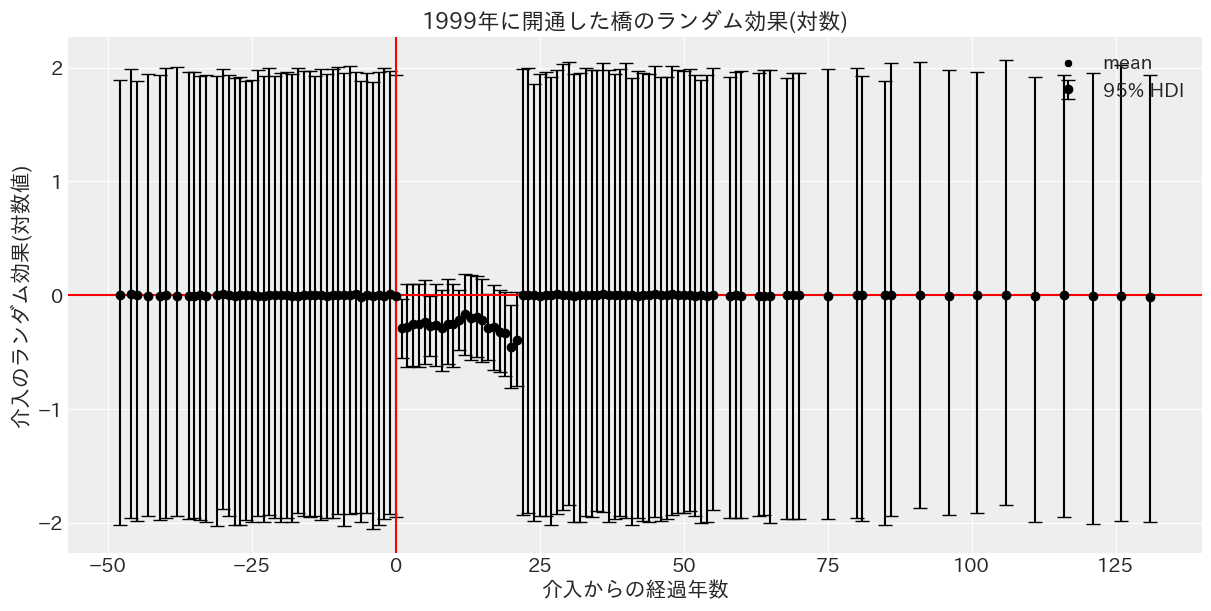

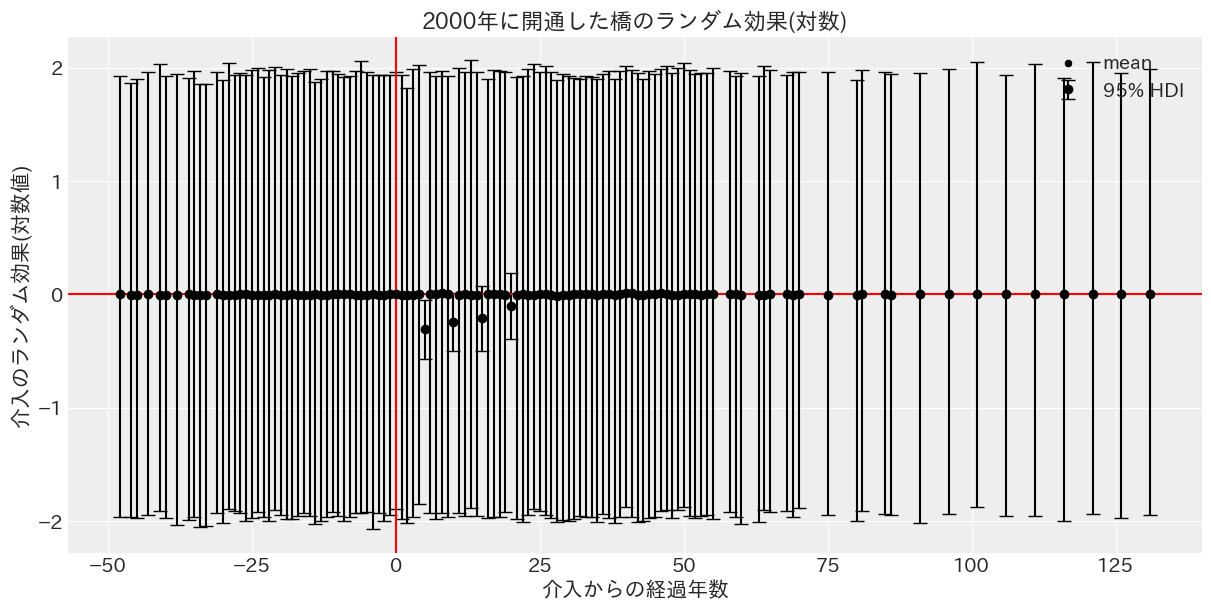

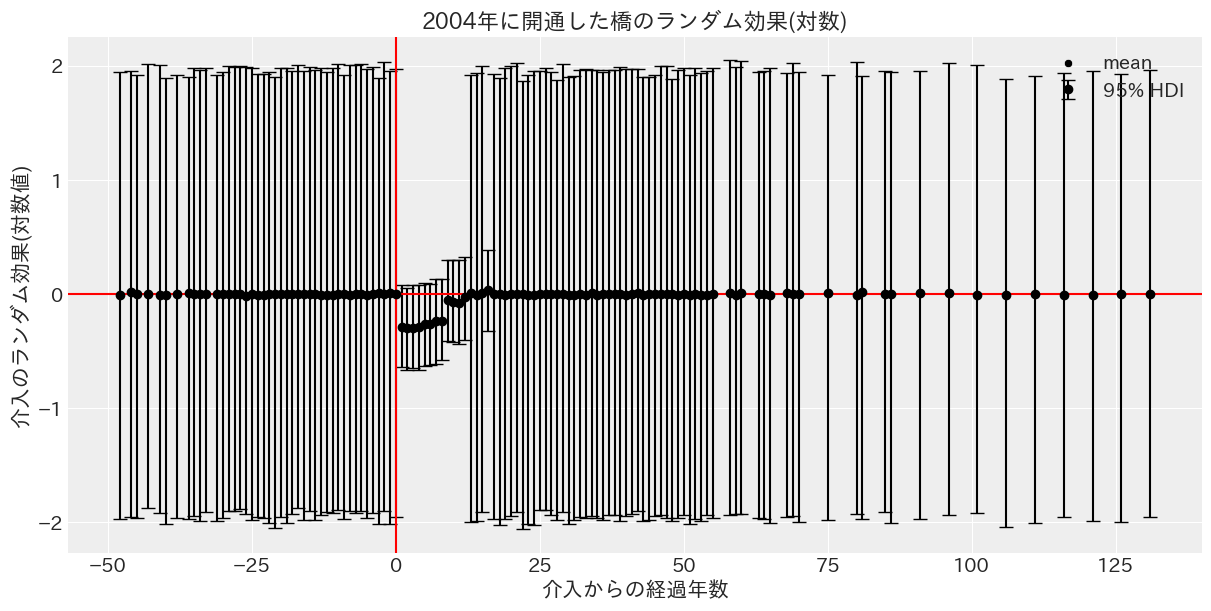

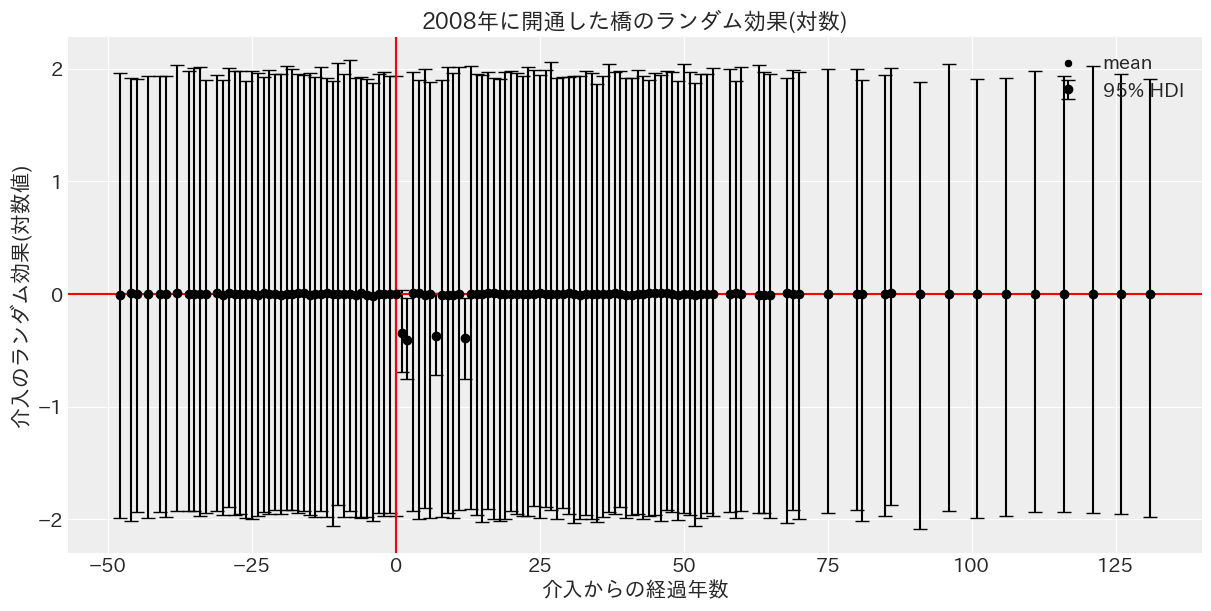

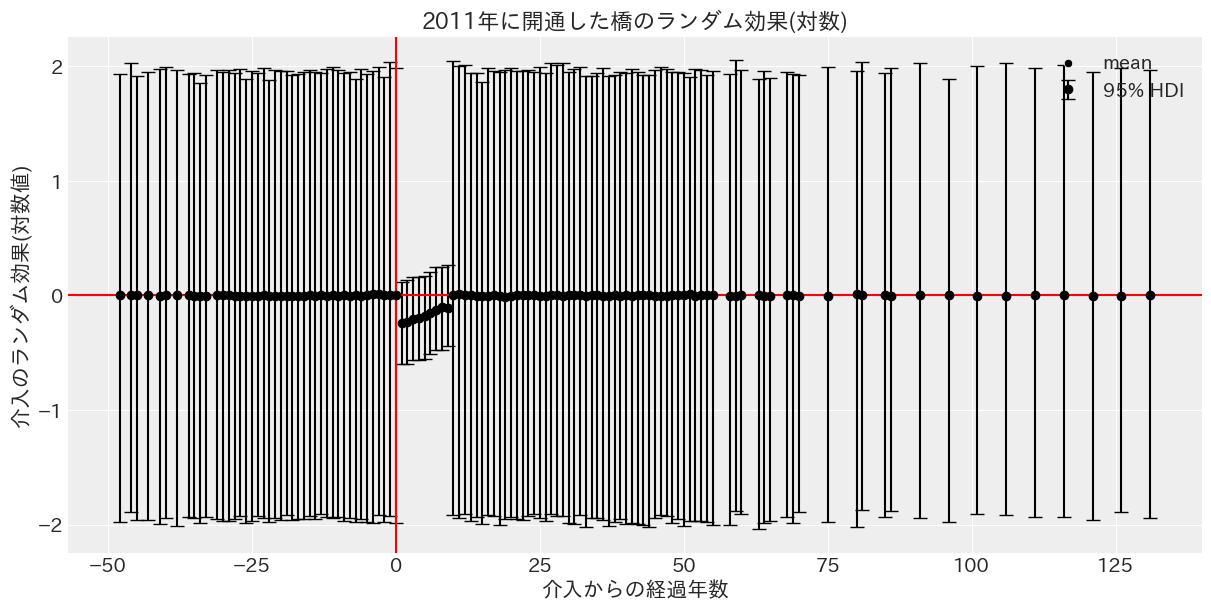

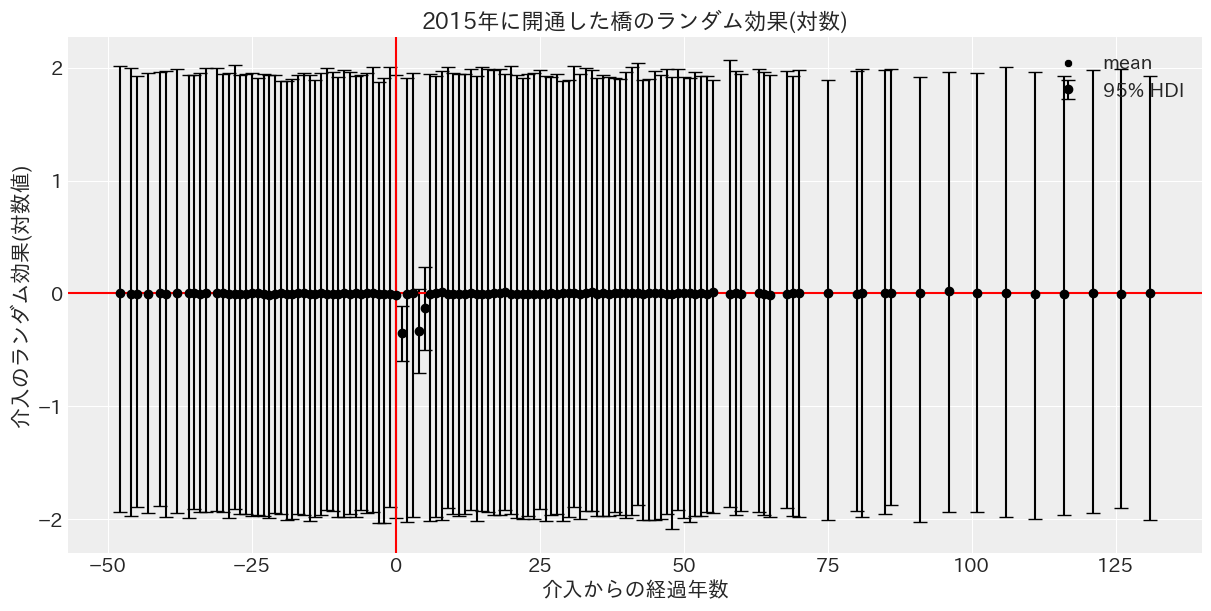

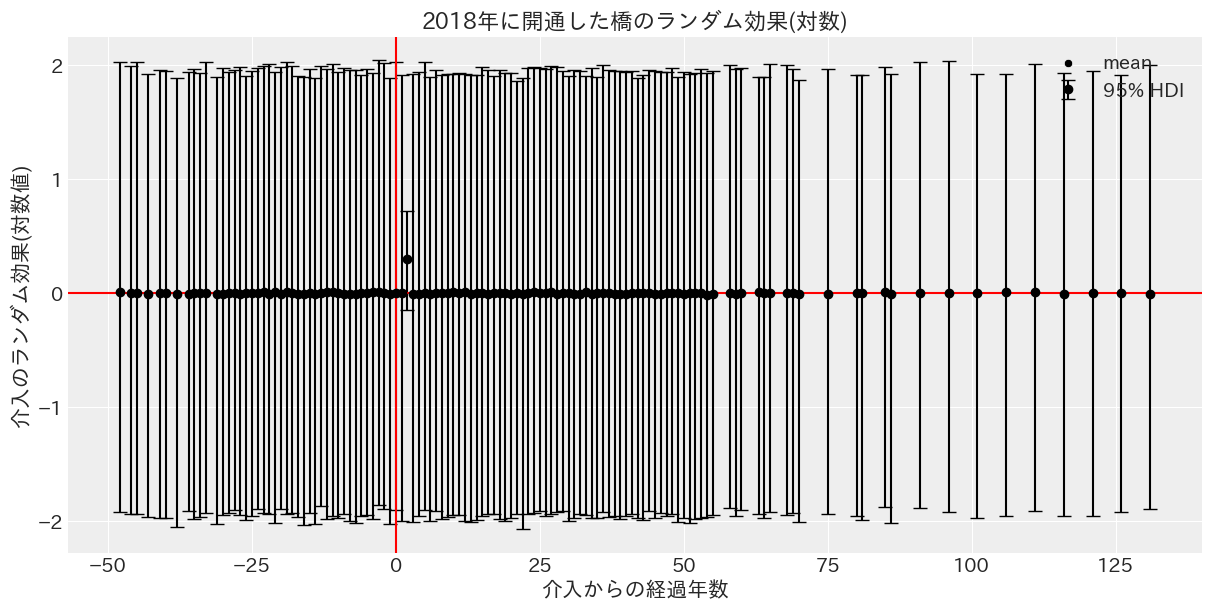

In [76]:
for treat in treat_list:
    plot_random_effect(gamma_df, treat, exp=False, errbar=True, save=True)